[LightGBM] [Info] Number of positive: 37525, number of negative: 74371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 111896, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335356 -> initscore=-0.684059
[LightGBM] [Info] Start training from score -0.684059
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.97071	valid_0's average_precision: 0.952025	valid_0's binary_logloss: 0.315011
First 20 predicted probabilities: [0.13385158 0.11343156 0.58957034 0.11550169 0.76658617 0.11473344
 0.1176535  0.77056466 0.11465207 0.11579155 0.5950675  0.18434941
 0.11646991 0.11342676 0.17560242 0.11534504 0.11616721 0.67911874
 0.113431

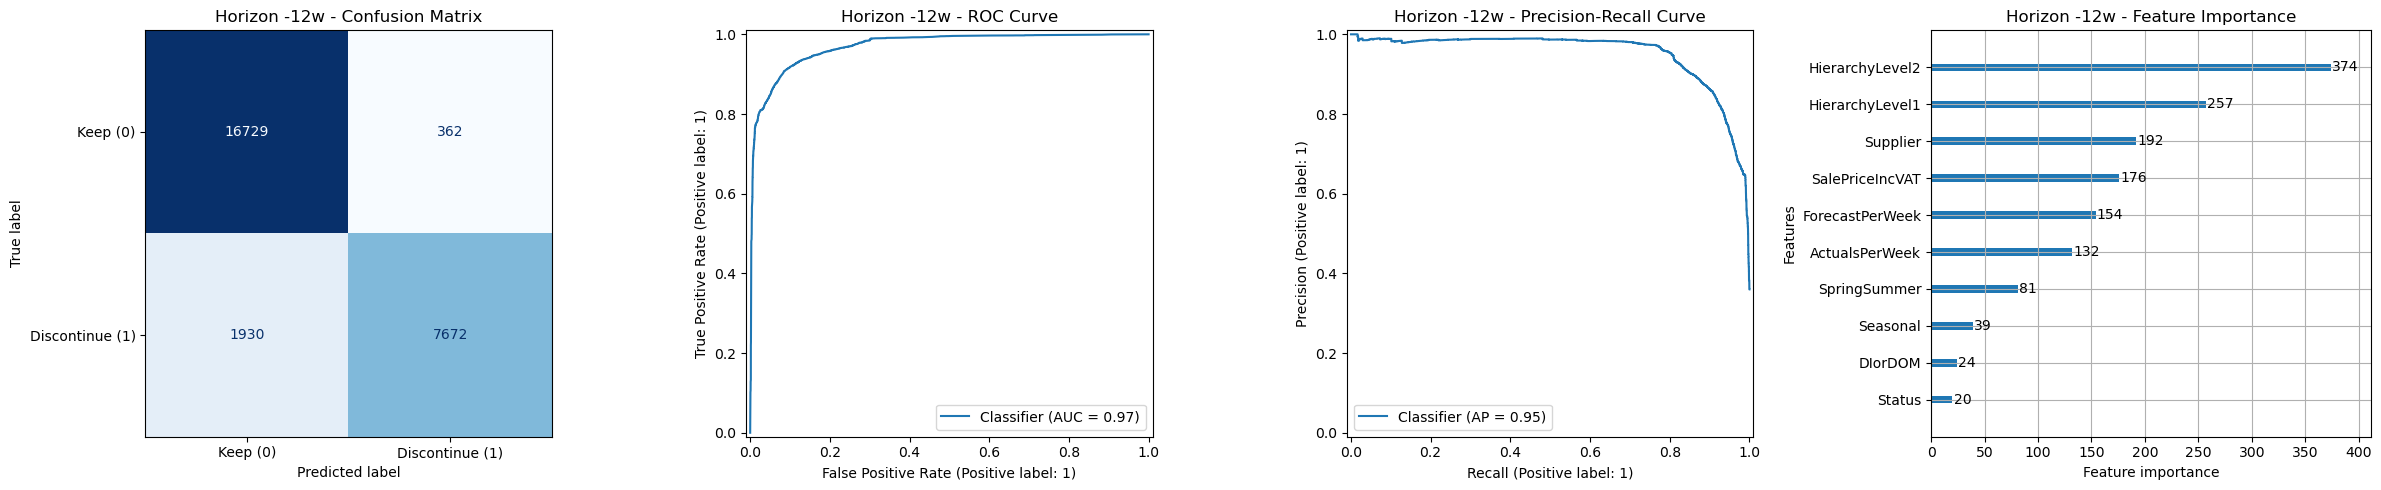

[LightGBM] [Info] Number of positive: 37353, number of negative: 75183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 112536, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331920 -> initscore=-0.699512
[LightGBM] [Info] Start training from score -0.699512
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.967693	valid_0's average_precision: 0.938853	valid_0's binary_logloss: 0.22733
Early stopping, best iteration is:
[84]	valid_0's auc: 0.967577	valid_0's average_precision: 0.93674	valid_0's binary_logloss: 0.227016
First 20 predicted probabilities: [0.86230152 0.00900165 0.55401502 0.00990839 0.97072199 0.01214343
 0.0154087  0.95180145 0.01259839 0.01590

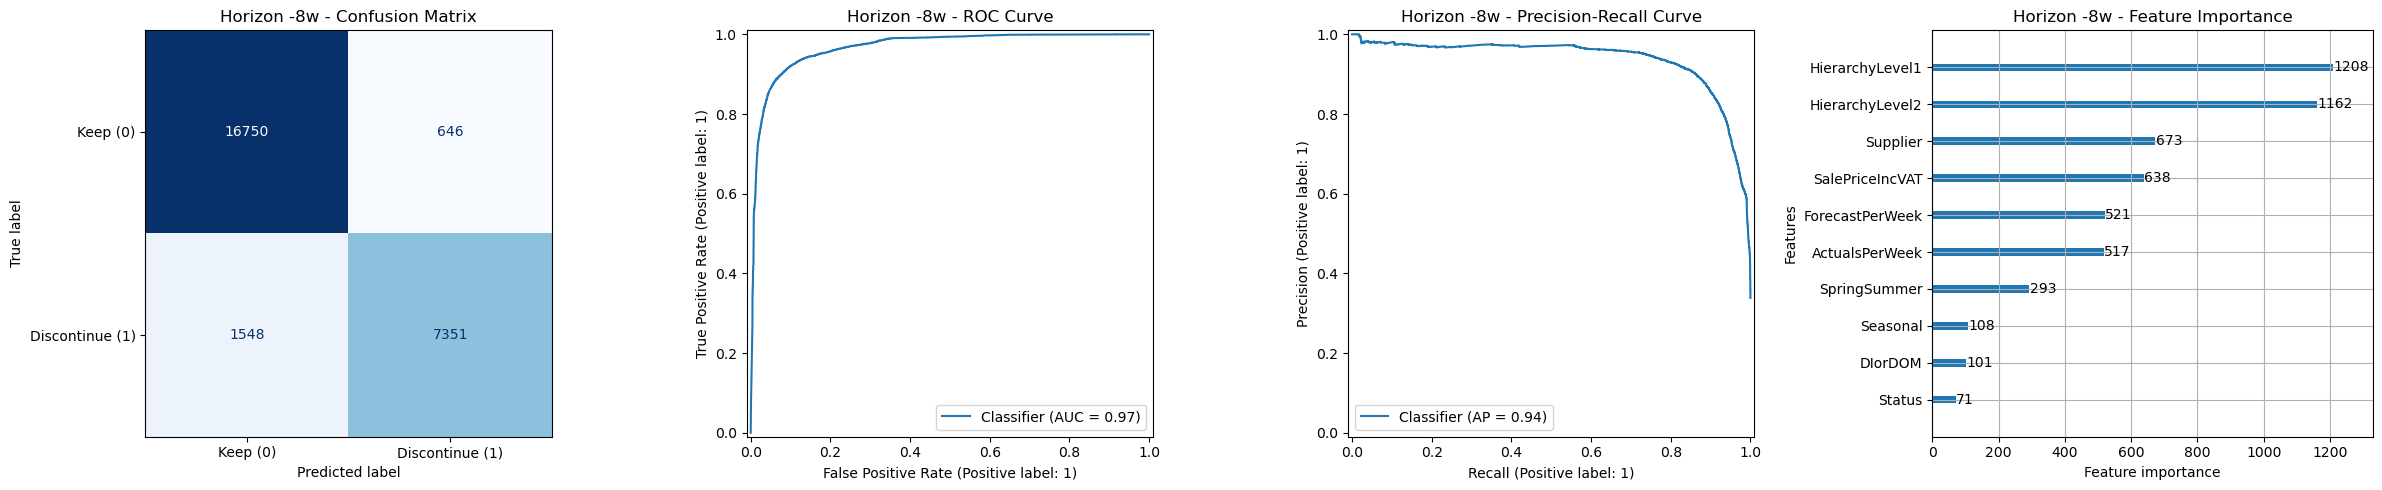

[LightGBM] [Info] Number of positive: 36452, number of negative: 75782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 112234, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324786 -> initscore=-0.731864
[LightGBM] [Info] Start training from score -0.731864
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.972806	valid_0's average_precision: 0.945465	valid_0's binary_logloss: 0.201921
Early stopping, best iteration is:
[130]	valid_0's auc: 0.973408	valid_0's average_precision: 0.949132	valid_0's binary_logloss: 0.201694
First 20 predicted probabilities: [0.95537901 0.0022748  0.37635735 0.00382597 0.99290559 0.00375923
 0.00978152 0.9887109  0.00562186 0.00

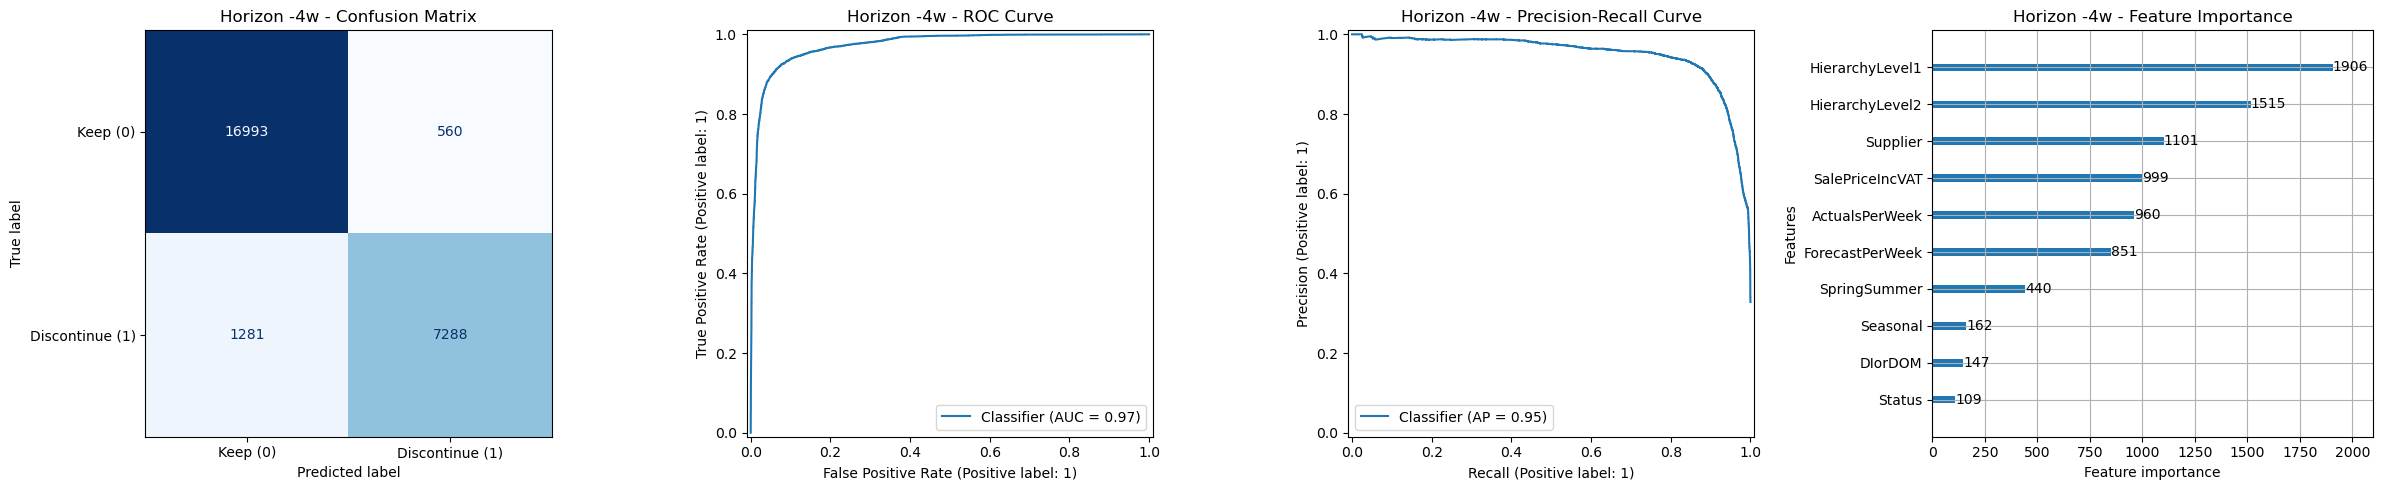

In [6]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, roc_curve, precision_recall_curve
)

from joblib import dump


df = pd.read_parquet("./output/filtered_dataset.parquet")
OUTPUT_DIR = "./output"
features = ["Supplier", "HierarchyLevel1", "HierarchyLevel2", 
            "DIorDOM", "Seasonal", "SpringSummer", "Status",
            "SalePriceIncVAT", "ForecastPerWeek", "ActualsPerWeek", "WeeksOut"]

target = "DiscontinuedTF"


def get_data_for_horizon(df, horizon):
    subset = df[df["WeeksOut"] == horizon].copy()
    
    X = subset[features].copy()
    y = subset[target]
    
    # Convert categoricals to "category" dtype
    cat_cols = X.select_dtypes(include=["object", "string"]).columns
    for col in cat_cols:
        X[col] = X[col].astype("category")
    
    return X, y, cat_cols

def build_model():
    return lgb.LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        num_leaves=64,
        learning_rate=0.05,
        n_estimators=2000,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

def evaluate_model(model, X_train, y_train, X_val, y_val, cat_cols, horizon):
    # Fit model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=["auc", "average_precision"],
        categorical_feature=list(cat_cols),
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)]
    )
    
    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    print("First 20 predicted probabilities:", y_proba[:20])
    # Save predictions vs actual
    preds_df = X_val.copy()
    preds_df["TrueLabel"] = y_val.values
    preds_df["PredictedLabel"] = y_pred
    preds_df["PredictedProb"] = y_proba
    
    preds_path = os.path.join(OUTPUT_DIR, f"predictions_horizon_{horizon}w.csv")
    preds_df.to_csv(preds_path, index=False)
    print(f"✅ Saved predictions for horizon {horizon} to {preds_path}")
    
    
    # Print metrics
    print(f"\n=== Horizon {horizon} weeks ===")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("Precision:", precision_score(y_val, y_pred))
    print("Recall:", recall_score(y_val, y_pred))
    print("F1 Score:", f1_score(y_val, y_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_proba))
    print("PR AUC:", average_precision_score(y_val, y_proba))
    
    # Plot results
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Keep (0)", "Discontinue (1)"])
    disp.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f"Horizon {horizon}w - Confusion Matrix")

    # ROC curve
    RocCurveDisplay.from_predictions(y_val, y_proba, ax=axes[1])
    axes[1].set_title(f"Horizon {horizon}w - ROC Curve")

    # PR curve
    PrecisionRecallDisplay.from_predictions(y_val, y_proba, ax=axes[2])
    axes[2].set_title(f"Horizon {horizon}w - Precision-Recall Curve")

    # Feature importance
    lgb.plot_importance(model, max_num_features=15, ax=axes[3])
    axes[3].set_title(f"Horizon {horizon}w - Feature Importance")

    plt.tight_layout()
    plt.show()


# ----------------------------
# Step 2: Run per horizon
# ----------------------------

horizons = [-12, -8, -4]

# Example: split by CatEdition
train_df = df[df["CatEdition"] <= 92]
val_df   = df[df["CatEdition"] == 93]

for horizon in horizons:
    X_train, y_train, cat_cols = get_data_for_horizon(train_df, horizon)
    X_val, y_val, _ = get_data_for_horizon(val_df, horizon)
    
    model = build_model()
    evaluate_model(model, X_train, y_train, X_val, y_val, cat_cols, horizon)


## 📊 Horizon Model Performance (-12w, -8w, -4w)

### 🔎 Key Observations
- Accuracy improves closer to refresh (**91% → 92.9%**).  
- Precision stays high (>91%) → very few false positives.  
- Recall increases (**80% → 85%**) → later models catch more discontinued products.  
- AUC remains excellent (>0.94).  

### 🧩 Feature Drivers
- **Category (Hierarchy levels)** dominate.  
- **Supplier** consistently important.  
- **Forecasts** matter earlier (-12w), while **actual sales & price** gain weight closer to -4w.  
- **Seasonality** remains relevant.  

### ✅ Business Value
- **-12w (Early Planning):** Early warning, high precision but may miss some discontinued items.  
- **-8w (Balanced):** Best trade-off; strong precision & recall for planning and negotiations.  
- **-4w (Execution):** Most reliable; ideal for clearance and stock stoppage, but limited lead time.  

### ⚖️ Strategic Recommendation
- **-12w** → Strategic foresight (suppliers, long-lead stock).  
- **-8w** → Balanced operational planning.  
- **-4w** → Final tactical execution.  
